# Fit NFW Density Profile

## Introduzione

Gli aloni di materia oscura sono strutture gravitazionalmente legate che svolgono un ruolo chiave nella formazione delle strutture cosmiche, agendo da nuclei gravitazionali intorno ai quali si aggrega la materia ordinaria, come gas e stelle, formando galassie e ammassi di galassie. La caratterizzazione del profilo di densità degli aloni ha molteplici applicazioni in studi cosmologici come la stima della massa di un ammasso di galassie da misure di lensing gravitazionale o lo studio delle proprietà della materia oscura.

Il profilo di densità proiettato degli aloni di materia oscura è adeguatamente descritto dal fit analitico (2D projected NFW profile):

$$ \Sigma(R, M, c, z) = 2 r_s \rho_s f(x) $$

dove $M$ è la massa dell'alone di materia oscura e $c$ la concentrazione; $r_s$ è il raggio caratteristico dell'ammasso ed è pari a:

$$ r_s = \frac{1}{c}\left(M\frac{3}{4 \pi 200 \rho_m (1+z)^3}\right)^{\frac{1}{3}} $$

dove $\rho_m$ è la densità media dell'universo approssimata a:

$$ \rho_m \simeq 0.286 \cdot 0.7^2 \cdot 2.7751428946 \cdot 10^{11} \left[\frac{\text{M}_{\odot}}{\text{Mpc}^3}\right]. $$

$\rho_s$ è la densità caratteristica dell'ammasso pari a:

$$ \begin{equation}
    \rho_s = \rho_m (1+z)^3 \delta_{char} \\
    \delta_{char} = \frac{200 c^3}{3 f_c} \\
    f_c = \text{ln}(1+c) - \frac{c}{1+c}.
\end{equation} $$

Infine $x = \frac{R}{r_s}$, con $R$ distanza dal centro dell'alone di materia oscura espressa in Mpc, e la funzione $f(x)$ è pari a:

$$ f(x) = \begin{cases}
              \frac{1}{x^2-1}\left[1-\frac{2}{\sqrt{1-x^2}}\text{arctanh}\sqrt{\frac{1-x}{1+x}}\right] &\quad \text{if}\space x<1 \\
              \frac{1}{3} &\quad \text{if}\space x=1 \\
              \frac{1}{x^2-1}\left[1-\frac{2}{\sqrt{x^2-1}}\text{arctan}\sqrt{\frac{x-1}{x+1}}\right] &\quad \text{if}\space x>1
          \end{cases} $$

## Punto a)

Implementare la funzione per calcolare $\Sigma(R, M, c, z)$ e mostrare in un grafico composto da 9 pannelli i profili di densità nell'intervallo $R \in [0.03, 1.0]$ Mpc, per le seguenti combinazioni di valori di massa e concentrazione:

$$ \begin{align}
    M& = [10^{13.5},\space 10^{14.0},\space 10^{15.0}] \space \text{M}_{\odot}; \\
    c& = [2,\space 5,\space 10]; \\
    z&= 0.0.
\end{align} $$

(Suggerimento: usare scala logaritmica per migliorare la visualizzazione).

### Implementazione

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

rho_m = 0.286 * 0.7**2 *2.7751428946e11

Per svolgere questo punto ho deciso di computare una matrice $\Sigma$ di shape (1000, 3, 3) con entrate:

$$ \Sigma_{ijk} = \Sigma(R_i, M_j, c_k, z) $$

dove $R$ è un numpyarray composto da 1000 valori compresi tra 0.03 Mpc e 1.0 Mpc equispaziati, mentre $M$ e $c$ sono a loro volta dei numpyarray contenenti i valori per i quali computare la funzione. Ho scelto questa metodologia di implementazione perché in questo modo sarebbe poi risultato molto semplice e intuitivo graficare i risultati come richiesto.

In [2]:
M = np.array([10**13.5, 10**14.0, 10**15.0])
c = np.array([2, 5, 10])
z = 0.
R = np.linspace(0.03,1.0,1000)

Ho proceduto computando, in ordine, $r_s$, $\rho_s$, $f(x)$ e in conclusione la matrice $\Sigma$. Per $r_s$ in particolare ho utilizzato il prodotto esterno implementando il metodo [`np.outer`](https://numpy.org/doc/stable/reference/generated/numpy.outer.html) di numpy:

In [3]:
r_s = np.outer(np.cbrt(3 * M / (4 * np.pi * 200 * rho_m * (1 + z)**3)), 1 / c)

In [4]:
f_c = np.log(1 + c) - c / (1 + c)
delta_char = 200 * c**3 / (3 * f_c)
rho_s = rho_m * (1 + z)**3 * delta_char

Per $f(x)$ è opportuno calcolare prima $x$. In questo caso ho utilizzato il metodo [`np.multiply.outer`](https://numpy.org/doc/stable/reference/generated/numpy.ufunc.outer.html#numpy.ufunc.outer), una generalizzazione di `np.outer` ad array con più di una dimensione:

In [5]:
x = np.multiply.outer(R, 1/r_s)

In una prima fase, per calcolare $f(x)$ avevo utilizzato una elif ladder e una matrice della stessa shape di $x$ composta interamente di 1 così da poter implementare [`np.less`](https://numpy.org/doc/stable/reference/generated/numpy.less.html) ed [`np.greater`](https://numpy.org/doc/stable/reference/generated/numpy.greater.html) per controllare la condizione desiderata elemento per elemento e inserire l'opportuno valore della funzione in ciascuna entrata. Questo metodo è però poco efficiente perché richiede di calcolare 9000 volte la funzione nel contesto di 3 cicli for innestati. Una soluzione migliore è invece osservare che le funzioni che definiscono f negli intervalli $x<1$ e $x>1$ hanno domini disgiunti e utilizzare questo fatto per migliorare l'efficienza del calcolo:

In [6]:
s1 = time.time()

ones = np.ones((1000, 3, 3))

f = np.empty((1000, 3, 3))
for i in range(1000):
    for j in range(3):
        for k in range(3):
            if np.less(x, ones)[i, j, k]:
                f[i, j, k] = (1 - (2 * np.arctanh(np.sqrt((1-x[i, j, k])/(1+x[i, j, k]))) / np.sqrt(1 - x[i, j, k]**2))) / (x[i, j, k]**2 - 1)
            elif np.greater(x, ones)[i, j, k]:
                f[i, j, k] = (1 - (2 * np.arctan(np.sqrt((x[i, j, k]-1)/(1+x[i, j, k]))) / np.sqrt(x[i, j, k]**2 - 1))) / (x[i, j, k]**2 - 1)
            else: 
                f[i, j, k] = 1./3

e1 = time.time()

In [7]:
s2 = time.time()

f1 = (1 - (2 * np.arctanh(np.sqrt((1 - x) / (1 + x))) / np.sqrt(1 - x**2))) / (x**2 - 1)
f2 = (1 - (2 * np.arctan(np.sqrt((x - 1) / (1 + x))) / np.sqrt(x**2 - 1))) / (x**2 - 1)
f1[np.isnan(f1)] = 0
f2[np.isnan(f2)] = 0
f = f1 + f2
f = np.where(f == 0., 1./3, f)

e2 = time.time()

C:\Users\Ghigu\AppData\Local\Temp\ipykernel_11612\1047644650.py:3: RuntimeWarning: invalid value encountered in sqrt
  f1 = (1 - (2 * np.arctanh(np.sqrt((1 - x) / (1 + x))) / np.sqrt(1 - x**2))) / (x**2 - 1)
C:\Users\Ghigu\AppData\Local\Temp\ipykernel_11612\1047644650.py:4: RuntimeWarning: invalid value encountered in sqrt
  f2 = (1 - (2 * np.arctan(np.sqrt((x - 1) / (1 + x))) / np.sqrt(x**2 - 1))) / (x**2 - 1)


Si può verificare la maggiore efficienza del secondo metodo confrontando i tempi di esecuzione:

In [8]:
print('Tempo metodo 1 =', e1-s1, 's')
print('Tempo metodo 2 =', e2-s2, 's')

Tempo metodo 1 = 0.09125351905822754 s
Tempo metodo 2 = 0.0010135173797607422 s


In conclusione, ho calcolato $\Sigma(R, M, c, z)$:

In [9]:
Sigma = 2* rho_s * r_s * f

Come anticipato, questo approccio al problema mi ha permesso di graficare i risultati ottenuti in modo semplice, iterando il comando di plot variando gli indici corrispondenti ai differenti valori di $M$ e $c$. Per rendere la rappresentazione più significativa ho inoltre fissato i valori minimi e massimi sulle ordinate per tutti e 9 i pannelli e ho impostato la scala logaritmica su entrambi gli assi per migliorare la visualizzazione, come suggerito.

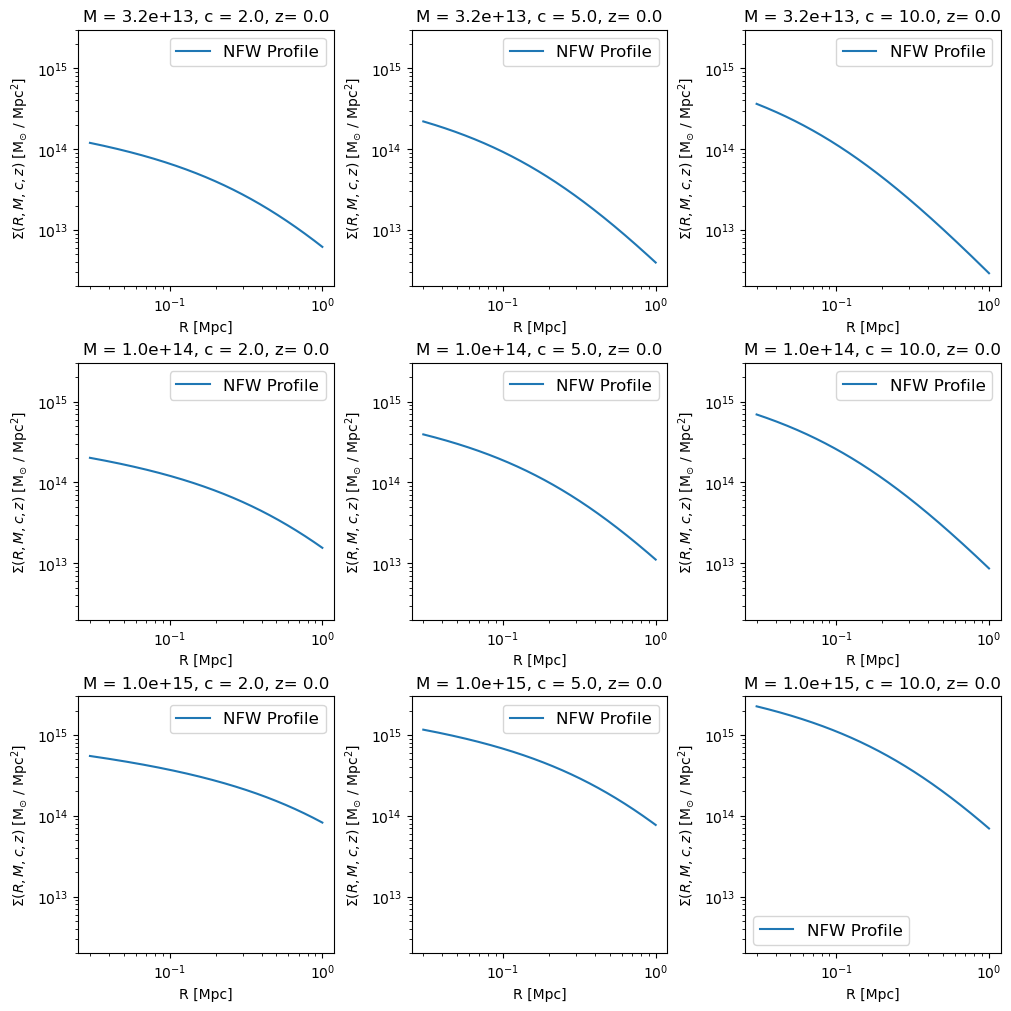

In [10]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10), layout = 'constrained')

for j in range(3):
    for k in range(3):
        axs[j, k].plot(R, Sigma[:, j, k], label = 'NFW Profile')
        axs[j, k].legend(fontsize = 'large')
        axs[j, k].set(xlabel = 'R [Mpc]', ylabel = r'$\Sigma(R, M, c, z)$ [M$_{\odot}$ / Mpc$^2$]',
                      xscale = 'log', yscale = 'log', ylim = [2e12, 3e15], title = 'M = %.1e, c = %.1f, z= 0.0' %(M[j], c[k]))

## Punto b)

Il file `halo_catalog.fits` contiene i profili di densità di 40103 aloni di materia oscura estratti da una simulazione cosmologica N-body, il loro redshift e la ricchezza, una somma pesata del numero di galassie che popolano l'alone e che funge da proxy per la massa. I nomi delle colonne contenenti i dati sono rispettivamente: 
* redshift = 'Z',
* ricchezza = 'LAMBDA_TR',
* profilo di densità = 'SIGMA_of_R' $\left[\frac{\text{M}_{\odot}}{\text{Mpc}^2}\right]$.

I valori di $R$ in [Mpc] a cui sono calcolati i profili di densità si trovano nel file `R_values.npy`.

### Punto b1)

Suddividere il catalogo nei 5 intervalli di ricchezza aventi come estremi $\lambda = [15, 20, 30, 45, 60, 200]$ e calcolare il redshift, profilo di densità medio e la sua deviazione standard in funzione di $R$ per ognuno di questi e mostrare i risultati in un grafico con 5 pannelli.

#### Implementazione

In [11]:
from astropy.io import fits
import pandas as pd

Per maneggiare il file `.fits` ho fatto riferimento alla [guida di `astropy`](https://docs.astropy.org/en/stable/io/fits/index.html). 

In primo luogo ho aperto il file e ho ricercato informazioni sulla Header Data Unit List (HDUL):

In [12]:
hdul = fits.open('halo_catalog.fits')
hdul.info()

Filename: halo_catalog.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     14   40103R x 3C   [E, E, 8E]   


Ho trovato che ci sono 2 HDU: Primary e una tabella. Ne ho dedotto che i dati si trovassero nell' HDU 1, ho proceduto quindi a salvarli e a chiudere il file.

In [13]:
data = hdul[1].data
hdul.close()

La variabile `data` così ottenuta ha per colonne dei numpyarray. Questo mi ha permesso di rappresentare i dati in un DataFrame, scelta fatta in modo da poterli manipolare con facilità, soprattutto nell'ottica di raggrupparli per intervalli di ricchezza. Per farlo ho inizialmente creato un DataFrame che contenesse solo le entrate della colonna 'SIGMA_R': questo perché nel file `halo_catalog.fits` tale colonna contiene in realtà un numpyarray a 2 dimensioni e per poter convertire la tabella in Pandas avevo bisogno di "spacchettare" quella colonna in più colonne.

In [14]:
SigR = data['SIGMA_of_R'].newbyteorder().byteswap()
df1 = pd.DataFrame(SigR, columns = ['SIGMA_of_R0', 'SIGMA_of_R1', 'SIGMA_of_R2', 'SIGMA_of_R3', 'SIGMA_of_R4', 
                                    'SIGMA_of_R5', 'SIGMA_of_R6', 'SIGMA_of_R7'])

Come si può vedere, oltre a quanto anticipato, ho applicato il metodo [`numpy.newbyteorder().byteswap()`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.byteswap.html). In una prima versione del codice non ero stato così accorto e più avanti nell'implementazione (in particolare nell'atto di effettuare il groupby per intervalli di ricchezza), sono incorso nell'errore:

"`Big-endian buffer not supported on little-endian compiler`"

Questo perché Pandas funziona correttamente solo se i dati salvati nel DataFrame o nella Serie in oggetto sono in native byte order, cioè little-endian (quantomeno nel caso di sistemi Linux o Windows). Al contrario nei file `.fits` i dati immagazzinati sono big-endian e questo causa un problema di compatibilità che necessita di essere risolto [invertendo l'endianess dei dati in input](https://pandas.pydata.org/pandas-docs/stable/user_guide/gotchas.html#byte-ordering-issues).

Dopo questo accorgimento, sono passato a creare un secondo DataFrame, contenente questa volta i dati relativi alle prime due colonne della tabella e dunque le ho concatenate per creare il DataFrame bersaglio.

In [15]:
data_dict = {'Z': data['Z'].newbyteorder().byteswap(), 'LAMBDA_TR': data['LAMBDA_TR'].newbyteorder().byteswap()}
df2 = pd.DataFrame(data_dict)
df = pd.concat([df2, df1], axis = 1)
df

,Z,LAMBDA_TR,SIGMA_of_R0,SIGMA_of_R1,SIGMA_of_R2,SIGMA_of_R3,SIGMA_of_R4,SIGMA_of_R5,SIGMA_of_R6,SIGMA_of_R7
0,0.502494,290.692261,2.351102e+15,1.992653e+15,1.496068e+15,1.186635e+15,8.963382e+14,6.253857e+14,3.943133e+14,2.285814e+14
1,0.601302,119.245781,2.107659e+15,1.980064e+15,1.652226e+15,1.229586e+15,9.864418e+14,7.124628e+14,4.493736e+14,2.624644e+14
2,0.208961,126.373863,1.814137e+15,1.739587e+15,1.344639e+15,1.121889e+15,8.703220e+14,5.941933e+14,3.668202e+14,1.864975e+14
3,0.212769,188.812729,2.349731e+15,1.945845e+15,1.539410e+15,1.077038e+15,7.059310e+14,4.613497e+14,2.969404e+14,1.913648e+14
4,0.458008,147.349625,2.240655e+15,1.679705e+15,1.314239e+15,1.120241e+15,8.280310e+14,5.703857e+14,3.796933e+14,2.315893e+14
...,...,...,...,...,...,...,...,...,...,...
40098,0.479437,9.510518,7.317734e+14,7.352522e+14,5.704476e+14,3.042415e+14,1.612240e+14,9.388085e+13,6.723513e+13,6.424537e+13
40099,0.599918,17.036392,5.234640e+14,4.248873e+14,3.092860e+14,2.059087e+14,1.372936e+14,8.645296e+13,4.359242e+13,2.579911e+13
40100,0.622782,8.831167,6.419276e+14,4.426898e+14,3.834843e+14,2.781025e+14,1.816492e+14,1.097785e+14,7.185037e+13,5.326193e+13
40101,0.535050,12.180819,3.163261e+14,3.317815e+14,2.491461e+14,1.719007e+14,1.450824e+14,1.283064e+14,8.723127e+13,5.760639e+13


Terminata la fase di setup del DataFrame, mi è stato semplice calcolare e rappresentare le grandezze desiderate sfruttando i metodi [`pandas.DataFrame.groupy`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) e [`pandas.DataFrame.loc`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html):

In [16]:
int_mean = df.groupby(pd.cut(df['LAMBDA_TR'], [15, 20, 30, 45, 60, 200])).mean()
int_std = df.groupby(pd.cut(df['LAMBDA_TR'], [15, 20, 30, 45, 60, 200])).std()
z_int_mean = int_mean.loc[:, ['Z']]
z_int_mean.rename(columns={'Z': 'Z_mean'}, inplace=True)
z_int_std = int_std.loc[:, ['Z']]
z_int_std.rename(columns={'Z': 'Z_std'}, inplace=True)
R_int_mean = int_mean.loc[:, ['SIGMA_of_R0', 'SIGMA_of_R1', 'SIGMA_of_R2', 'SIGMA_of_R3', 'SIGMA_of_R4',
                              'SIGMA_of_R5', 'SIGMA_of_R6', 'SIGMA_of_R7']]
R_int_mean.rename(columns={'SIGMA_of_R0': 'SIGMA_of_R0_mean', 'SIGMA_of_R1': 'SIGMA_of_R1_mean',
                           'SIGMA_of_R2': 'SIGMA_of_R2_mean', 'SIGMA_of_R3': 'SIGMA_of_R3_mean',
                           'SIGMA_of_R4': 'SIGMA_of_R4_mean', 'SIGMA_of_R5': 'SIGMA_of_R5_mean',
                           'SIGMA_of_R6': 'SIGMA_of_R6_mean', 'SIGMA_of_R7': 'SIGMA_of_R7_mean'}, inplace=True)
R_int_std = int_std.loc[:, ['SIGMA_of_R0', 'SIGMA_of_R1', 'SIGMA_of_R2', 'SIGMA_of_R3', 'SIGMA_of_R4',
                              'SIGMA_of_R5', 'SIGMA_of_R6', 'SIGMA_of_R7']]
R_int_std.rename(columns={'SIGMA_of_R0': 'SIGMA_of_R0_std', 'SIGMA_of_R1': 'SIGMA_of_R1_std',
                           'SIGMA_of_R2': 'SIGMA_of_R2_std', 'SIGMA_of_R3': 'SIGMA_of_R3_std',
                           'SIGMA_of_R4': 'SIGMA_of_R4_std', 'SIGMA_of_R5': 'SIGMA_of_R5_std',
                           'SIGMA_of_R6': 'SIGMA_of_R6_std', 'SIGMA_of_R7': 'SIGMA_of_R7_std'}, inplace=True)

In [17]:
z_int = pd.concat([z_int_mean, z_int_std], axis = 1)
z_int

,Z_mean,Z_std
LAMBDA_TR,,
"(15, 20]",0.460090,0.123092
"(20, 30]",0.463887,0.121813
"(30, 45]",0.459208,0.123646
"(45, 60]",0.456439,0.123037
"(60, 200]",0.441161,0.122742


In [18]:
R_int_mean

,SIGMA_of_R0_mean,SIGMA_of_R1_mean,SIGMA_of_R2_mean,SIGMA_of_R3_mean,SIGMA_of_R4_mean,SIGMA_of_R5_mean,SIGMA_of_R6_mean,SIGMA_of_R7_mean
LAMBDA_TR,,,,,,,,
"(15, 20]",6.040370e+14,4.900458e+14,3.598957e+14,2.441868e+14,1.573150e+14,9.940772e+13,6.326566e+13,4.258762e+13
"(20, 30]",6.717476e+14,5.498711e+14,4.078379e+14,2.780886e+14,1.798401e+14,1.131488e+14,7.073311e+13,4.623129e+13
"(30, 45]",8.322382e+14,6.875067e+14,5.164361e+14,3.578354e+14,2.345928e+14,1.480616e+14,9.084872e+13,5.603594e+13
"(45, 60]",1.017487e+15,8.481862e+14,6.493962e+14,4.575311e+14,3.030807e+14,1.918116e+14,1.166462e+14,6.985587e+13
"(60, 200]",1.299284e+15,1.092726e+15,8.503404e+14,6.101899e+14,4.143562e+14,2.673323e+14,1.639046e+14,9.581197e+13


In [19]:
R_int_std

,SIGMA_of_R0_std,SIGMA_of_R1_std,SIGMA_of_R2_std,SIGMA_of_R3_std,SIGMA_of_R4_std,SIGMA_of_R5_std,SIGMA_of_R6_std,SIGMA_of_R7_std
LAMBDA_TR,,,,,,,,
"(15, 20]",2.640365e+14,1.893752e+14,1.290308e+14,8.427349e+13,5.494038e+13,3.674195e+13,2.582108e+13,1.894787e+13
"(20, 30]",2.909992e+14,2.158597e+14,1.503459e+14,9.890763e+13,6.334698e+13,4.086933e+13,2.733401e+13,1.925362e+13
"(30, 45]",3.577725e+14,2.718182e+14,1.921912e+14,1.287568e+14,8.286741e+13,5.236009e+13,3.307377e+13,2.167616e+13
"(45, 60]",4.315102e+14,3.348032e+14,2.392007e+14,1.605941e+14,1.020653e+14,6.255899e+13,3.837411e+13,2.473522e+13
"(60, 200]",5.590717e+14,4.439427e+14,3.350374e+14,2.319237e+14,1.544334e+14,9.987915e+13,6.196603e+13,3.787068e+13


Si noti che ho scelto di rappresentare media e deviazione standard del redshift in un unico DataFrame per una maggiore semplicità nella lettura dei dati. Lo stesso non ho fatto per media e deviazione standard della funzione di fit poiché il DataFrame sarebbe stato troppo largo e una rappresentazione del genere sarebbe risultata quindi più scomoda di una con due DataFrame distinti posizionati uno sopra l'altro.

Infine, per graficare media e deviazione standard del fit NFW ho optato per uno scatter plot, dato che con solo 8 valori di R non sarebbe stato significativo un plot semplice come quello al punto a). Ho inoltre scelto di rappresentare le deviazioni standard come punti oltre che come barre d'errore così da poter mostrare che anche esse, oltre al valore di aspettazione, aumentano con la ricchezza.

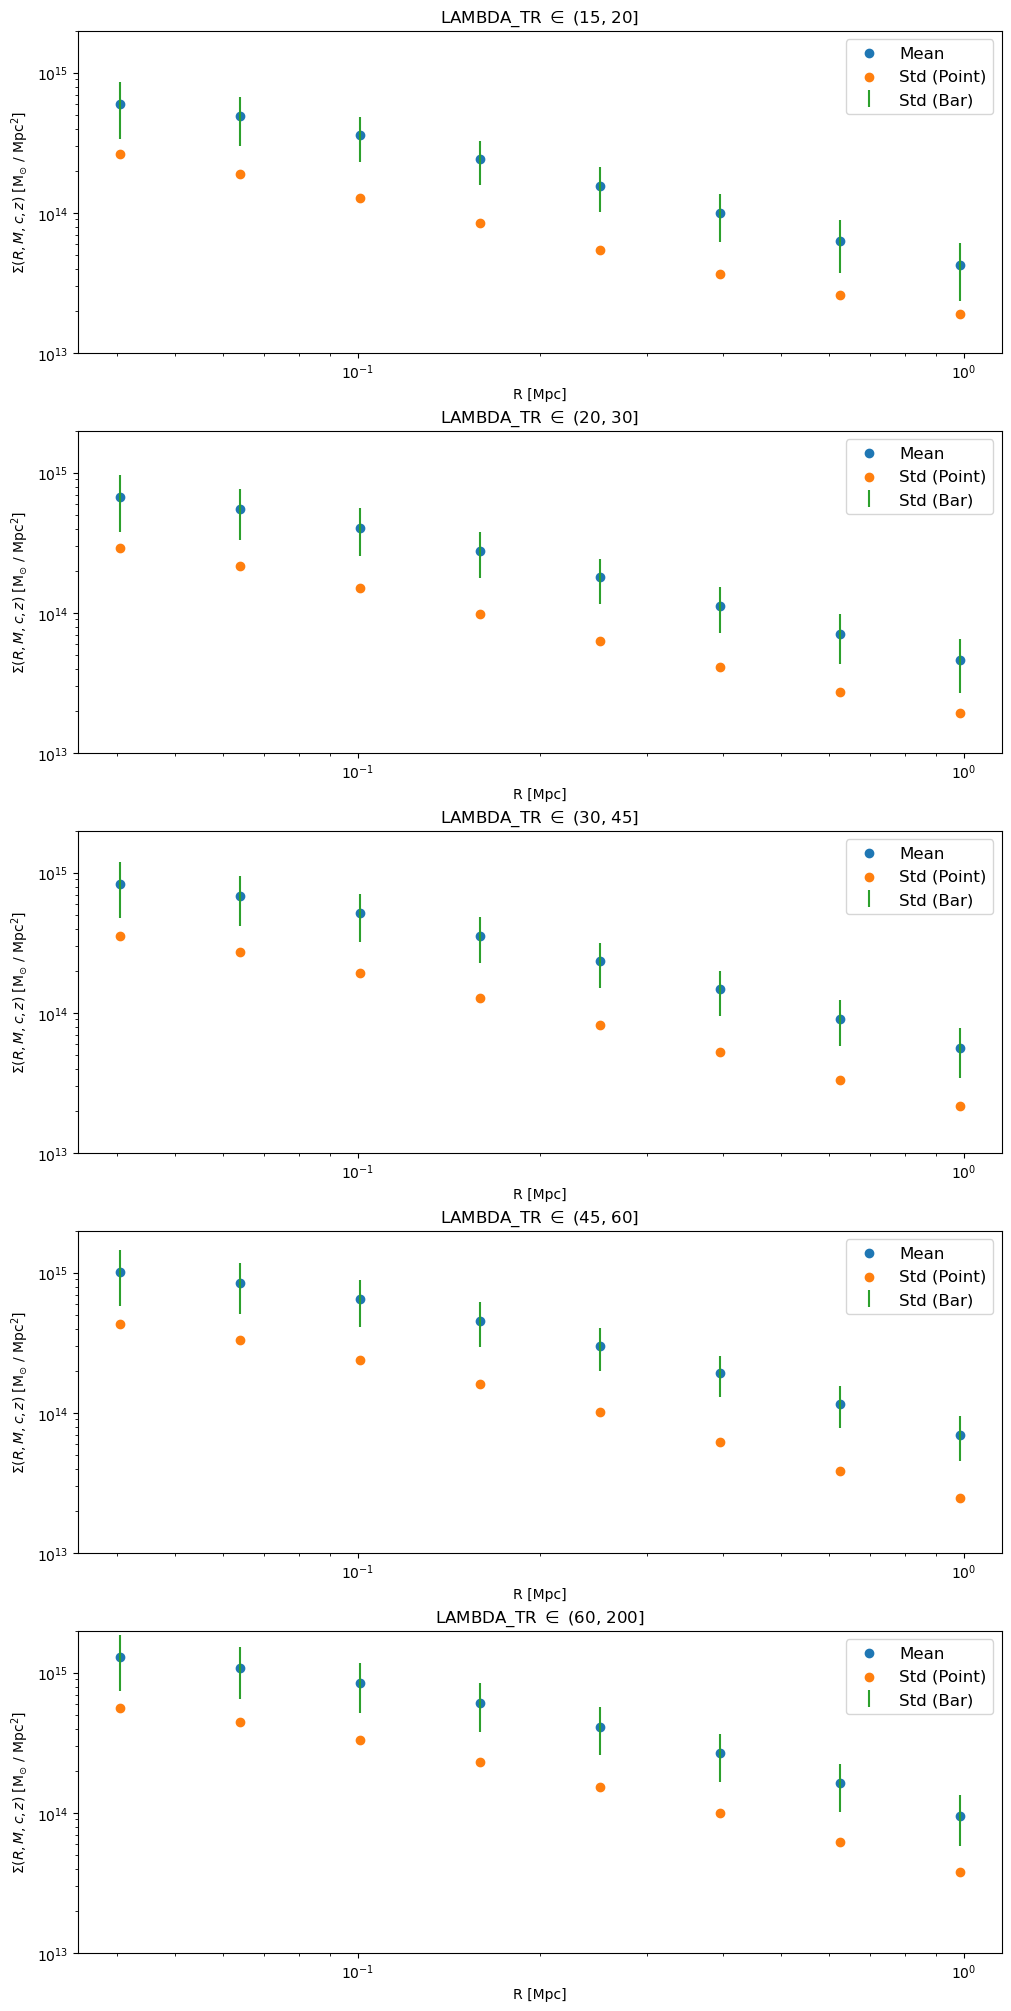

In [20]:
R = np.load('R_values.npy')
lamb = np.array([15, 20, 30, 45, 60, 200])

fig, axs = plt.subplots(5, figsize=(10, 20), layout = 'constrained')

for i in range(5):
    axs[i].scatter(R, R_int_mean.T.to_numpy()[:,i], label = 'Mean')
    axs[i].scatter(R, R_int_std.T.to_numpy()[:,i], color = 'tab:orange', label = 'Std (Point)')
    axs[i].errorbar(R, R_int_mean.T.to_numpy()[:,i], R_int_std.T.to_numpy()[:,i], fmt='none', color = 'tab:green', label = 'Std (Bar)')
    axs[i].legend(fontsize = 'large')
    axs[i].set(xlabel = 'R [Mpc]', ylabel = r'$\Sigma(R, M, c, z)$ [M$_{\odot}$ / Mpc$^2$]',
               xscale = 'log', yscale = 'log', ylim = [1e13, 2e15], title = r'LAMBDA_TR $\in$ (%i, %i]' %(lamb[i],lamb[i+1]))

### Punto b2)

Usando il fit analitico NFW, stimare per ogni bin di ricchezza la massa (log$_{10}(M)$) e la concentrazione media. A tal scopo si assuma una likelihood Gaussiana utilizzando le matrici di covarianza fornite nel file `covariance_matrices.npy` per ogni intervallo di ricchezza e i seguenti _prior_ uniformi per i parametri:

* log$_{10}(M) \in [13, 16]$,
* $c \in [0.2, 20]$;

per ogni bin di ricchezza si utilizzi il relativo redshift medio. Usare il software `emcee` per derivare i _posteriors_ sui parametri

#### Implementazione

Per prima cosa riporto i comandi che ho utilizzato per installare [`emcee`](https://emcee.readthedocs.io/en/stable/user/install/) e [`pygtc`](https://pygtc.readthedocs.io/en/latest/installation.html):

In [21]:
#!python -m pip install -U pip
#!pip install -U setuptools setuptools_scm pep517
#!pip install -U emcee
#!pip install pygtc

In [22]:
import emcee
from scipy.optimize import minimize

Anzitutto ho creato delle variabili apposite per semplificare la notazione nello svolgimento:

In [23]:
CovMat = np.load('covariance_matrices.npy')

Sigma_R = R_int_mean.to_numpy()
z = z_int['Z_mean'].to_numpy()

Ho definito la funzione di fit in modo simile a quanto fatto nel punto a):

In [24]:
def Sigma(Rad, lM, c, rdsft_i):
    
    r_s = np.cbrt(3 * 10**lM / (4 * np.pi * 200 * rho_m * (1 + rdsft_i)**3)) / c
    
    f_c = np.log(1 + c) - c / (1 + c)
    delta_char = 200 * c**3 / (3 * f_c)
    rho_s = rho_m * (1 + rdsft_i)**3 * delta_char
    
    x = Rad / r_s
    
    f1 = (1 - (2 * np.arctanh(np.sqrt((1 - x) / (1 + x))) / np.sqrt(1 - x**2))) / (x**2 - 1)
    f2 = (1 - (2 * np.arctan(np.sqrt((x - 1) / (1 + x))) / np.sqrt(x**2 - 1))) / (x**2 - 1)
    f1[np.isnan(f1)] = 0
    f2[np.isnan(f2)] = 0
    f = f1 + f2
    f = np.where(f == 0., 1./3, f)
    
    return 2 * r_s * rho_s * f

Ho definito log_prior, log_likelihood e log_posterior coerentemente a quanto indicato:

In [25]:
def log_prior(param):
    lM, c = param
    if (13 < lM < 16 and 0.2 < c < 20):
        return 0.0
    return -np.inf

def log_likelihood(param, Denprof, Rad, rdsft, TCOV):
    lM, c = param
    
    th_Sigma = Sigma(Rad, lM, c, rdsft)
    
    iTCOV = np.linalg.inv(TCOV)
    
    residuals = (Denprof - th_Sigma).T
    
    p, _ = TCOV.shape
    lognormalization = - 0.5 * (p * np.log(2 * np.pi) + np.log(np.linalg.det(TCOV)))
    exponent = -0.5 * np.sum(residuals @ iTCOV * residuals)
    return np.nansum(lognormalization + exponent)

def log_posterior(param, Denprof, Rad, rdsft, TCOV):
    lp = -log_prior(param)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(param, Denprof, Rad, rdsft, TCOV)

Prima di far partire il campionamento con `emcee` ho implementato il metodo [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) per ottenere una buona stima dei _posteriors_ in modo da poterli utilizzare come punto di partenza per il campionamento MCMC. Volendo ottenere i _posteriors_ per i 5 intervalli di ricchezza ho inserito i risultati del minimize in una lista così da alleggerire il codice all'atto di lanciare `emcee`. Per tutta la parte che segue ho utilizzato come riferimento l'[esempio riportato nella guida di `emcee`](https://emcee.readthedocs.io/en/stable/tutorials/line/) adattandolo leggermente alle mie esigenze:

In [26]:
param = [14.5, 3.0]

nll = lambda *args: -log_posterior(*args)
initial = np.array(param) 
soln0 = minimize(nll, initial, args = (Sigma_R[0], R, z[0], CovMat[0]))
soln = [soln0, soln0, soln0, soln0, soln0]
print(soln0.x, log_likelihood(soln0.x, Sigma_R[0], R, z[0], CovMat[0]))
for k in range(4):
    soln[k + 1] = minimize(nll, initial, args = (Sigma_R[k + 1], R, z[k + 1], CovMat[k + 1]))
    print(soln[k + 1].x, log_likelihood(soln[k + 1].x, Sigma_R[k + 1], R, z[k + 1], CovMat[k + 1]))

[14.33028386  2.6771188 ] -261.57026998461106
[14.40885267  2.79773218] -262.4791011391321
[14.56837273  3.06710808] -264.11006868888046
[14.72062514  3.31349587] -265.4032262533883
[14.92337929  3.57161652] -268.5799472740994


C:\Users\Ghigu\AppData\Local\Temp\ipykernel_11612\1569001428.py:11: RuntimeWarning: invalid value encountered in sqrt
  f1 = (1 - (2 * np.arctanh(np.sqrt((1 - x) / (1 + x))) / np.sqrt(1 - x**2))) / (x**2 - 1)
C:\Users\Ghigu\AppData\Local\Temp\ipykernel_11612\1569001428.py:12: RuntimeWarning: invalid value encountered in sqrt
  f2 = (1 - (2 * np.arctan(np.sqrt((x - 1) / (1 + x))) / np.sqrt(x**2 - 1))) / (x**2 - 1)


In [27]:
nparams = len(param)

pos = soln[0].x * (1 + 1e-4 * np.random.randn(32, nparams))
nwalkers, ndim = pos.shape
sampler0 = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args = (Sigma_R[0], R, z[0], CovMat[0]))
sampler0.run_mcmc(pos, 2000, progress=True)
sampler = [sampler0, sampler0, sampler0, sampler0, sampler0]

for i in range(4):
    pos = soln[i + 1].x * (1+1e-4 * np.random.randn(32, nparams))
    nwalkers, ndim = pos.shape
    sampler[i + 1] = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args = (Sigma_R[i + 1], R, z[i + 1], CovMat[i + 1]))
    sampler[i + 1].run_mcmc(pos, 2000, progress=True);

C:\Users\Ghigu\AppData\Local\Temp\ipykernel_11612\1569001428.py:11: RuntimeWarning: invalid value encountered in sqrt
  f1 = (1 - (2 * np.arctanh(np.sqrt((1 - x) / (1 + x))) / np.sqrt(1 - x**2))) / (x**2 - 1)
C:\Users\Ghigu\AppData\Local\Temp\ipykernel_11612\1569001428.py:12: RuntimeWarning: invalid value encountered in sqrt
  f2 = (1 - (2 * np.arctan(np.sqrt((x - 1) / (1 + x))) / np.sqrt(x**2 - 1))) / (x**2 - 1)
100%|██████████| 2000/2000 [00:08<00:00, 222.51it/s]


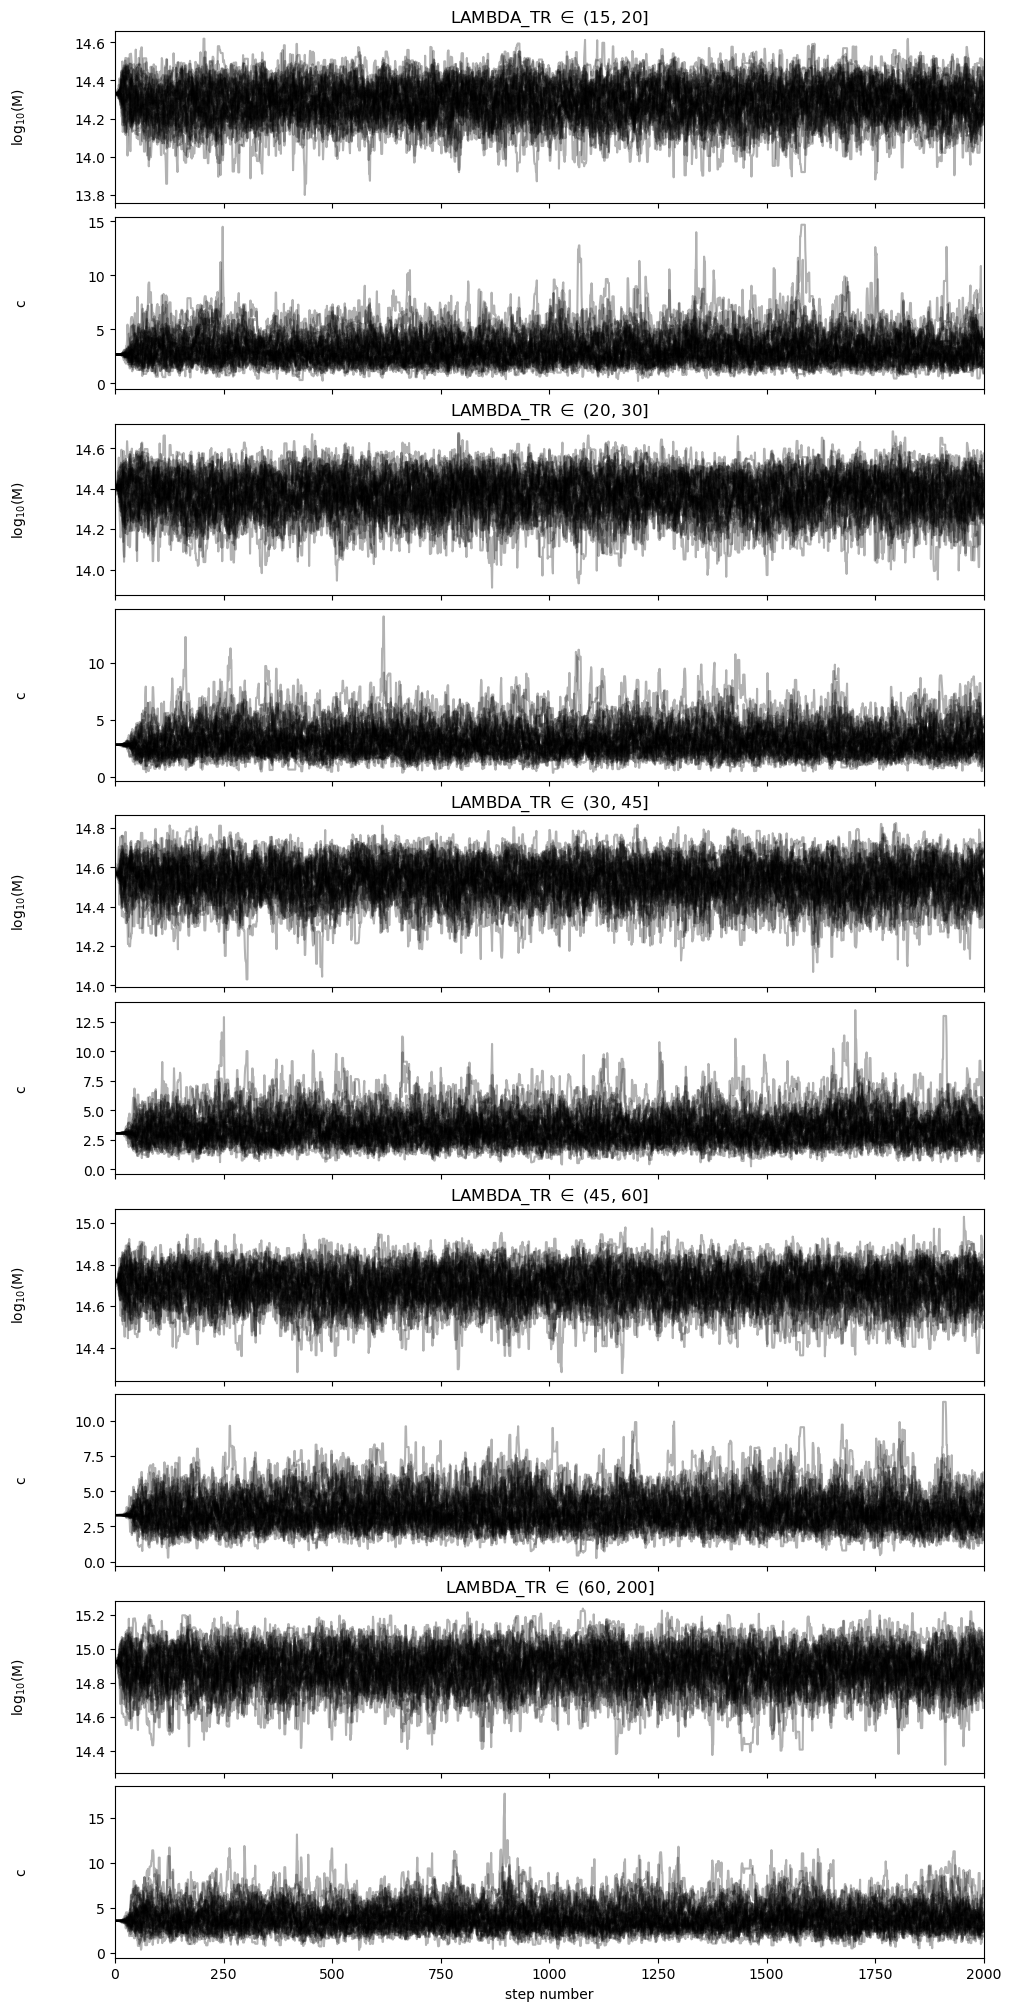

In [28]:
fig, axes = plt.subplots(10, figsize=(10, 20), layout = 'constrained',sharex=True)

samples0 = sampler[0].get_chain()
samples = [samples0, samples0, samples0, samples0, samples0]

for k in range(4):
    samples[k + 1] = sampler[k + 1].get_chain()

ylab = [r'log$_{10}$(M)', 'c']    

for w in range(5):
    for i in range(ndim):
        ax = axes[2 * w + i]
        ax.plot(samples[w][:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples[w]))
        ax.yaxis.set_label_coords(-0.1, 0.5)
        ax.set_ylabel('%s' %(ylab[i]))
        if i == 0:
            ax.set_title(r'LAMBDA_TR $ \in $ (%i, %i]' %(lamb[w], lamb[w + 1]))

axes[-1].set_xlabel("step number");

L'andamento di white noise dei grafici della catena suggeriscono che il campionamento sia stato eseguito correttamente.

### Punto b3)

Riportare il valore di best-fit, il valor medio ed errore associato ad ogni parametro; fare un grafico triangolare per ogni intervallo di ricchezza per mostrare i _posteriors_ ottenuti sui due parametri. Verificare la bontà del fit calcolando il $\chi^2$ per i best-fit parameters e confrontando i dati con ~100 valori di $M$ e $c$ estratti dalle catene; commentare i risultati.

#### Implementazione

In [29]:
import pygtc
from scipy.stats import chi2

Ho cominciato calcolando i tempi di correlazione per ciascun intervallo così da poter stimare in quanti step si esaurisce la fase di burn-in:

In [30]:
for w in range(5):
    print(sampler[w].get_autocorr_time())

[27.69969443 27.07296355]
[27.55758845 27.39937222]
[27.70367899 28.67431668]
[26.9907273  30.33245366]
[25.69732208 27.17212555]


Il tempo di autocorrelazione è circa di 30 step, quindi per essere sicuro di utilizzare solo dei valori pertinenti per i parametri ho scartato i primi 100 valori della catena:

In [31]:
flat_samples0 = sampler[0].get_chain(discard = 100, flat = True)
flat_samples = [flat_samples0, flat_samples0, flat_samples0, flat_samples0, flat_samples0]

for k in range(4):
    flat_samples[k + 1] = sampler[k + 1].get_chain(discard = 100, flat = True)

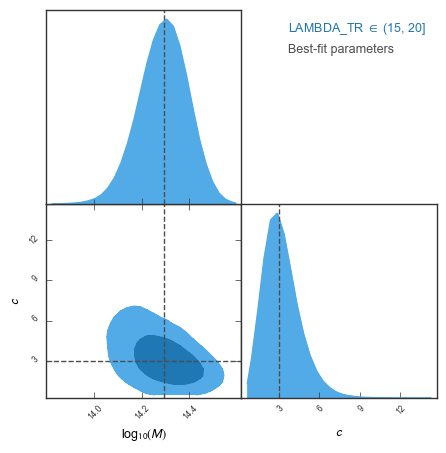

In [32]:
GTC_0 = pygtc.plotGTC(chains = flat_samples[0],
                      chainLabels = (r'LAMBDA_TR $\in$ (15, 20]'),
                      paramNames=[r'log$_{10}(M)$','$c$'],
                      truths = (np.median(flat_samples[0][:, 0]), np.median(flat_samples[0][:, 1])),
                      truthLabels = ('Best-fit parameters'),
                      figureSize='MNRAS_page')



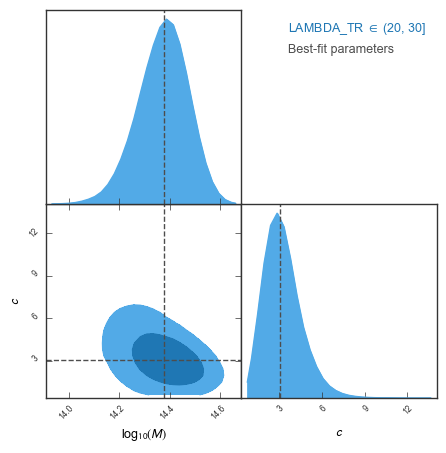

In [33]:
GTC_1 = pygtc.plotGTC(chains = flat_samples[1],
                      chainLabels = (r'LAMBDA_TR $\in$ (20, 30]'),
                      paramNames=[r'log$_{10}(M)$','$c$'],
                      truths = (np.median(flat_samples[1][:, 0]), np.median(flat_samples[1][:, 1])),
                      truthLabels = ('Best-fit parameters'),
                      figureSize='MNRAS_page')



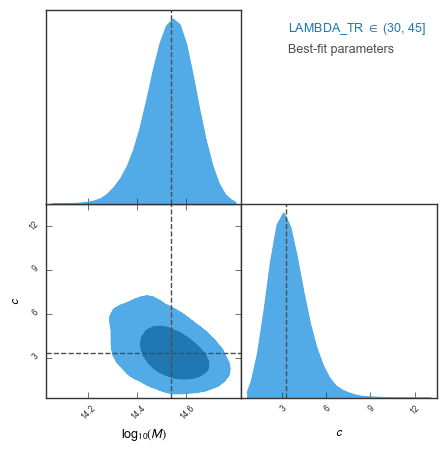

In [34]:
GTC_2 = pygtc.plotGTC(chains = flat_samples[2],
                      chainLabels = (r'LAMBDA_TR $\in$ (30, 45]'),
                      paramNames=[r'log$_{10}(M)$','$c$'],
                      truths = (np.median(flat_samples[2][:, 0]), np.median(flat_samples[2][:, 1])),
                      truthLabels = ('Best-fit parameters'),
                      figureSize='MNRAS_page')



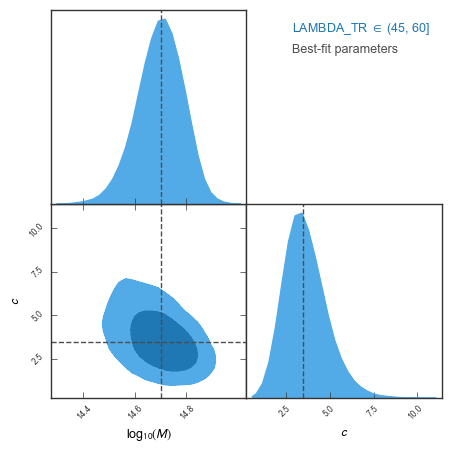

In [35]:
GTC_3 = pygtc.plotGTC(chains = flat_samples[3],
                      chainLabels = (r'LAMBDA_TR $\in$ (45, 60]'),
                      paramNames=[r'log$_{10}(M)$','$c$'],
                      truths = (np.median(flat_samples[3][:, 0]), np.median(flat_samples[3][:, 1])),
                      truthLabels = ('Best-fit parameters'),
                      figureSize='MNRAS_page')



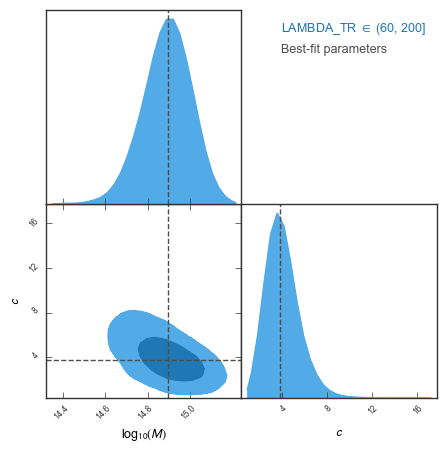

In [36]:
GTC_4 = pygtc.plotGTC(chains = flat_samples[4],
                      chainLabels = (r'LAMBDA_TR $\in$ (60, 200]'),
                      paramNames=[r'log$_{10}(M)$','$c$'],
                      truths = (np.median(flat_samples[4][:, 0]), np.median(flat_samples[4][:, 1])),
                      truthLabels = ('Best-fit parameters'),
                      figureSize='MNRAS_page')



Come best-fit parameters ho scelto di utilizzare le mediane dei sample in quanto nessuna delle Gaussiane dei parametri inferiti è ben centrata nell'intervallo del prior, come si può notare dai grafici precedenti. In particolare nel caso di $c$, dove le distribuzioni sono pesantemente spostate verso il minimo dell'intervallo, utilizzare la media avrebbe comportato una sostanziale sovrastima della soluzione.

In [37]:
bf_lM = np.empty(5)
bf_c = np.empty(5)
mean_lM = np.empty(5)
mean_c = np.empty(5)
std_lM = np.empty(5)
std_c = np.empty(5)

for w in range(5):
    bf_lM[w] = np.median(flat_samples[w][:, 0])
    bf_c[w] = np.median(flat_samples[w][:, 1])
    mean_lM[w] = flat_samples[w][:,0].mean()
    mean_c[w] = flat_samples[w][:,1].mean()
    std_lM[w] = flat_samples[w][:,0].std()
    std_c[w] = flat_samples[w][:,1].std()

Per semplicità di visualizzazione ho riportato i risultati di bestfit, media e deviazione standard in due DataFrame:

In [38]:
dictM = {'log_10(M)_bestfit': bf_lM, 'log_10(M)_mean': mean_lM, 'log_10(M)_std': std_lM}
M_res = pd.DataFrame(dictM).rename(index = {0: 'LAMBDA_TR in (15, 20]', 1: 'LAMBDA_TR in (20, 30]', 2: 'LAMBDA_TR in (30, 45]',
                                           3: 'LAMBDA_TR in (45, 60]', 4: 'LAMBDA_TR in (60, 200]'})
M_res

,log_10(M)_bestfit,log_10(M)_mean,log_10(M)_std
"LAMBDA_TR in (15, 20]",14.294813,14.290775,0.098976
"LAMBDA_TR in (20, 30]",14.378294,14.372087,0.096133
"LAMBDA_TR in (30, 45]",14.540013,14.534981,0.094721
"LAMBDA_TR in (45, 60]",14.701191,14.696806,0.085378
"LAMBDA_TR in (60, 200]",14.894343,14.889005,0.111231


In [39]:
dictc = {'c_bestfit': bf_c, 'c_mean': mean_c, 'c_std': std_c}
c_res = pd.DataFrame(dictc).rename(index = {0: 'LAMBDA_TR in (15, 20]', 1: 'LAMBDA_TR in (20, 30]', 2: 'LAMBDA_TR in (30, 45]',
                                           3: 'LAMBDA_TR in (45, 60]', 4: 'LAMBDA_TR in (60, 200]'})
c_res

,c_bestfit,c_mean,c_std
"LAMBDA_TR in (15, 20]",2.983930,3.182662,1.316389
"LAMBDA_TR in (20, 30]",3.054232,3.219629,1.264643
"LAMBDA_TR in (30, 45]",3.302038,3.460041,1.252558
"LAMBDA_TR in (45, 60]",3.472231,3.617507,1.175768
"LAMBDA_TR in (60, 200]",3.793195,3.972023,1.411049


Per valutare l'attendibilità dei risultati di best fit ottenuti ho calcolato le statistiche di test utilizzando:

* come dati, le medie dei fit NFW su ogni intervallo di ricchezza,
* come valori di aspettazione, i valori assunti dalla funzione $\Sigma(R, M, c, z)$ valutata per i parametri di best-fit, per il valor medio del redshift per ogni dato intervallo di ricchezza e per gli 8 valori di `r_values.npy`,
* come varianze, i valori nelle diagonali delle matrici di covarianza di `covariance_matrices.npy`:

In [40]:
t = np.empty(5)
var = np.empty([5, 8])

for k in range(5):
    for i in range(8):
        var[k, i] = CovMat[k, i, i]

for w in range(5):
    x_i = Sigma_R[w]
    mu_i = Sigma(R, bf_lM[w], bf_c[w], z[w])
    t[w] = np.sum((x_i - mu_i)**2 / var[w])

print(t)

[0.7207597  0.57417126 0.37613145 0.23894685 0.14594526]


C:\Users\Ghigu\AppData\Local\Temp\ipykernel_11612\1569001428.py:11: RuntimeWarning: invalid value encountered in sqrt
  f1 = (1 - (2 * np.arctanh(np.sqrt((1 - x) / (1 + x))) / np.sqrt(1 - x**2))) / (x**2 - 1)
C:\Users\Ghigu\AppData\Local\Temp\ipykernel_11612\1569001428.py:12: RuntimeWarning: invalid value encountered in sqrt
  f2 = (1 - (2 * np.arctan(np.sqrt((x - 1) / (1 + x))) / np.sqrt(x**2 - 1))) / (x**2 - 1)


Fissato il p-value a 0.05, il valore di riferimento nella tabella di $\chi^2$ è 14.067. Le statistiche di test ottenute sono più piccole di questo valore di più di un ordine di grandezza, fatto che suggerisce una possibile sovrastima dell'errore. Assumendo come valori di aspettazione per il calcolo delle statistiche di test i valori di $\Sigma(R, M, c, z)$ calcolati per coppie di parametri estratti casualmente dalla Markov-Chain si osserva un fenomeno simile:

In [41]:
rdn_values = np.empty([5, 100, 2])
for k in range(5):
    for i in range(2):
        for j in range(100):
            rdn_values[k, j, i] = flat_samples[k][np.random.randint(0, flat_samples[k].shape[0]), i]

t_rdn = np.empty([5, 100])        

for k in range(5):
    for j in range(100):
        x_i = Sigma_R[k]
        mu_i = Sigma(R, rdn_values[k, j, 0], rdn_values[k, j, 1], z[k])
        t_rdn[k, j] = np.sum((x_i - mu_i)**2 / var[k])
    
print(t_rdn)

[[ 1.19835006  2.3992069   1.02224476  5.75421795  3.06815509  4.69985246
   3.63266726  1.46125035  4.3872145   1.52904288  1.15153285  5.59161549
   7.0117706   2.74085061  4.0708001   9.48598595  2.1856098   4.51348776
   2.9307404   5.23524858  5.68214867  4.31844377  2.56192643  6.89451701
   1.3050876   0.81036702  1.67960279  0.86514493  1.77428196  1.14765697
  16.32604721  1.39584717  2.43668412  2.75854508  2.00116722  3.32478166
   0.62818936  6.04011692  5.90253404 13.22604699  0.89919264 10.74486938
   1.91290646  0.58212129  3.00859936  1.44001053  6.26958016  1.19840034
  15.37876833  2.27312503  3.41660439  4.8668078   5.60941445  0.6286357
   1.01688394  5.39121926  3.38079413  7.12979102  2.365293    1.73236623
   8.21670393  0.8624986   5.02364484  3.55245828  1.0786524   6.30483407
   1.49596602  1.95816636  1.29003106  0.72194876  2.11538156  1.68565279
   3.09666393  5.29762701  0.68086582  1.51244216  3.65875876  1.28111453
   1.05613624  3.13756292  4.34956056  

C:\Users\Ghigu\AppData\Local\Temp\ipykernel_11612\1569001428.py:11: RuntimeWarning: invalid value encountered in sqrt
  f1 = (1 - (2 * np.arctanh(np.sqrt((1 - x) / (1 + x))) / np.sqrt(1 - x**2))) / (x**2 - 1)
C:\Users\Ghigu\AppData\Local\Temp\ipykernel_11612\1569001428.py:12: RuntimeWarning: invalid value encountered in sqrt
  f2 = (1 - (2 * np.arctan(np.sqrt((x - 1) / (1 + x))) / np.sqrt(x**2 - 1))) / (x**2 - 1)


Per concludere ho graficato la funzione $\Sigma(R, M, c, z)$ calcolata per i best-fit parameters insieme alle medie dei dati relativi ai 5 intervalli di ricchezza. Ho anche incluso il fit di una $\Sigma(R, M, c, z)$ calcolata per una coppia di parametri estratta casualmente dalla catena.

C:\Users\Ghigu\AppData\Local\Temp\ipykernel_11612\1569001428.py:11: RuntimeWarning: invalid value encountered in sqrt
  f1 = (1 - (2 * np.arctanh(np.sqrt((1 - x) / (1 + x))) / np.sqrt(1 - x**2))) / (x**2 - 1)
C:\Users\Ghigu\AppData\Local\Temp\ipykernel_11612\1569001428.py:12: RuntimeWarning: invalid value encountered in sqrt
  f2 = (1 - (2 * np.arctan(np.sqrt((x - 1) / (1 + x))) / np.sqrt(x**2 - 1))) / (x**2 - 1)
C:\Users\Ghigu\AppData\Local\Temp\ipykernel_11612\1569001428.py:11: RuntimeWarning: invalid value encountered in sqrt
  f1 = (1 - (2 * np.arctanh(np.sqrt((1 - x) / (1 + x))) / np.sqrt(1 - x**2))) / (x**2 - 1)
C:\Users\Ghigu\AppData\Local\Temp\ipykernel_11612\1569001428.py:12: RuntimeWarning: invalid value encountered in sqrt
  f2 = (1 - (2 * np.arctan(np.sqrt((x - 1) / (1 + x))) / np.sqrt(x**2 - 1))) / (x**2 - 1)
C:\Users\Ghigu\AppData\Local\Temp\ipykernel_11612\1569001428.py:11: RuntimeWarning: invalid value encountered in sqrt
  f1 = (1 - (2 * np.arctanh(np.sqrt((1 - x) / (1

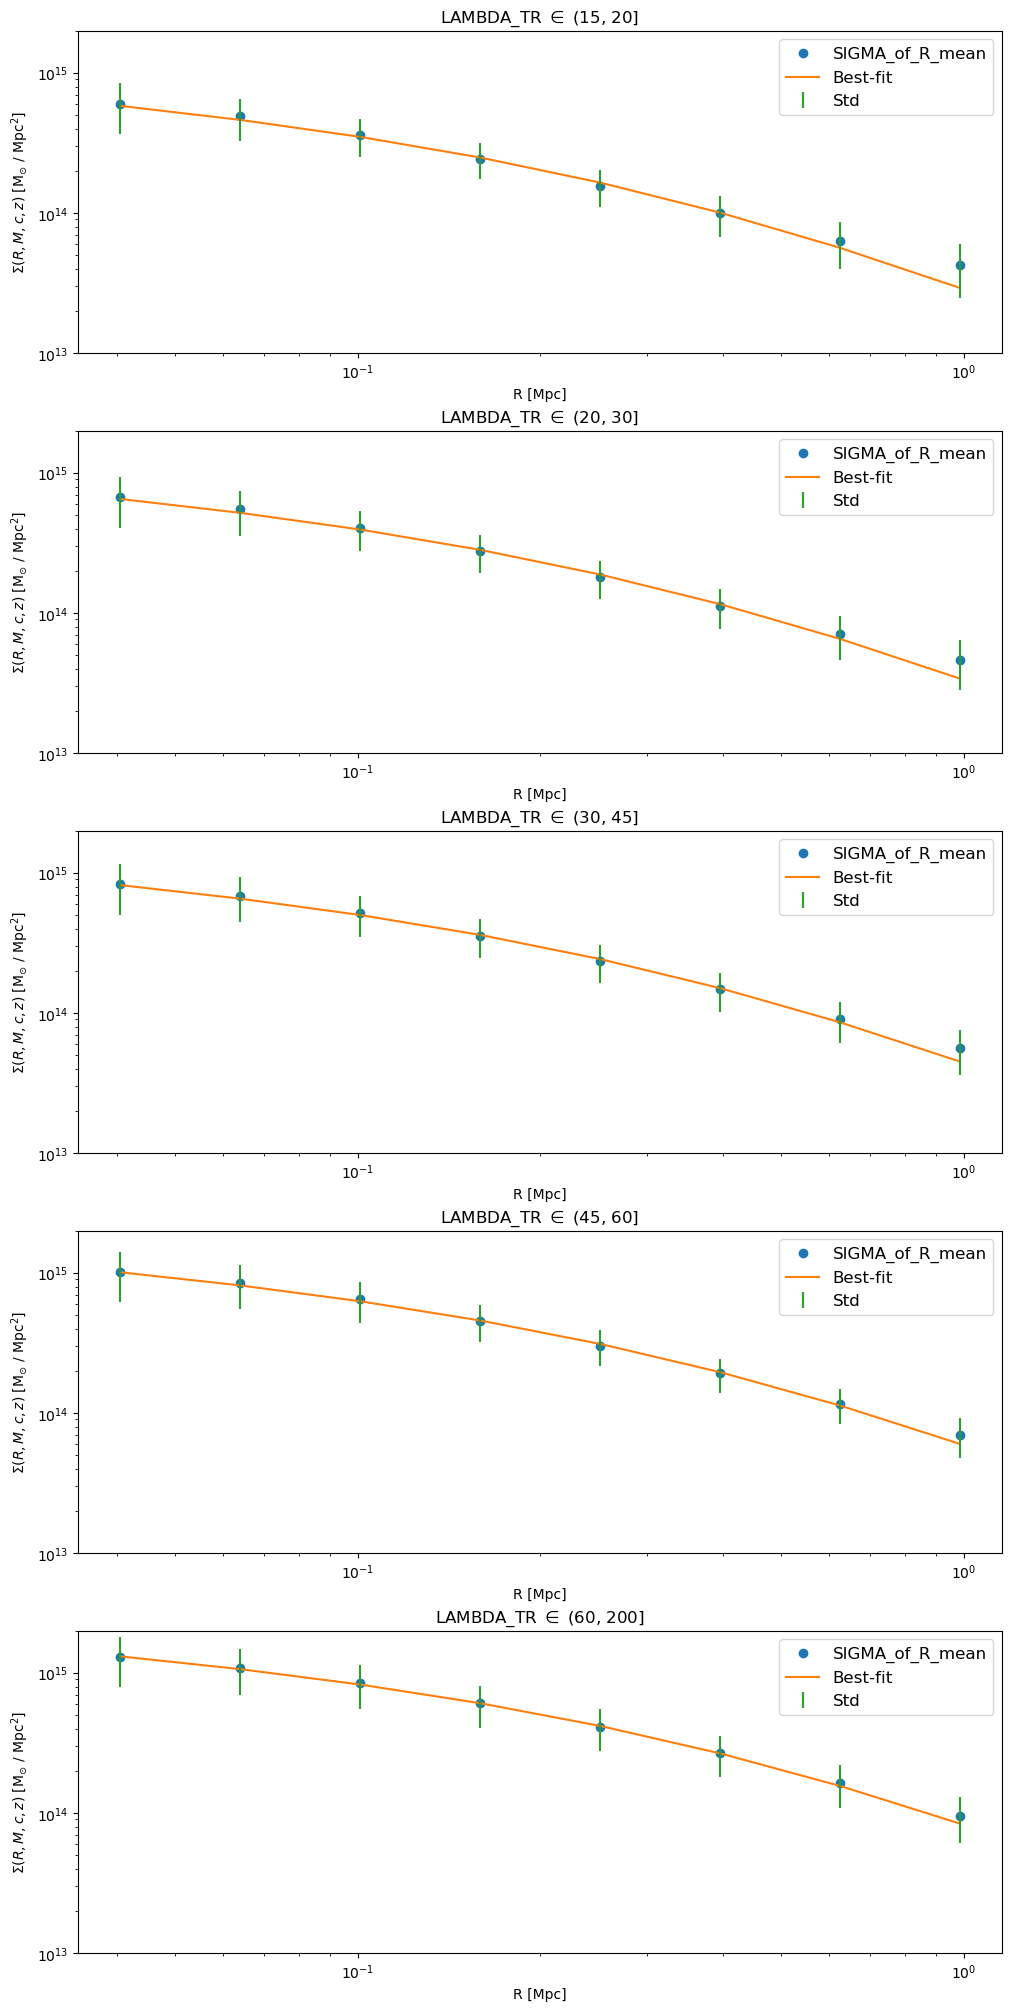

In [42]:
fig, axs = plt.subplots(5, figsize = (10, 20), layout = 'constrained')

for i in range(5):
    axs[i].scatter(R, R_int_mean.T.to_numpy()[:,i], label = 'SIGMA_of_R_mean')
    axs[i].plot(R, Sigma(R, bf_lM[i], bf_c[i], z[i]), color = 'tab:orange', label = 'Best-fit')
    axs[i].errorbar(R, R_int_mean.T.to_numpy()[:,i], np.sqrt(var[i]), fmt = 'none', color = 'tab:green', label = 'Std')
    axs[i].legend(fontsize = 'large')
    axs[i].set(xlabel = 'R [Mpc]', ylabel = r'$\Sigma(R, M, c, z)$ [M$_{\odot}$ / Mpc$^2$]',
               xscale = 'log', yscale = 'log', ylim = [1e13, 2e15], title = r'LAMBDA_TR $\in$ (%i, %i]' %(lamb[i],lamb[i+1]))

C:\Users\Ghigu\AppData\Local\Temp\ipykernel_11612\1569001428.py:11: RuntimeWarning: invalid value encountered in sqrt
  f1 = (1 - (2 * np.arctanh(np.sqrt((1 - x) / (1 + x))) / np.sqrt(1 - x**2))) / (x**2 - 1)
C:\Users\Ghigu\AppData\Local\Temp\ipykernel_11612\1569001428.py:12: RuntimeWarning: invalid value encountered in sqrt
  f2 = (1 - (2 * np.arctan(np.sqrt((x - 1) / (1 + x))) / np.sqrt(x**2 - 1))) / (x**2 - 1)
C:\Users\Ghigu\AppData\Local\Temp\ipykernel_11612\1569001428.py:11: RuntimeWarning: invalid value encountered in sqrt
  f1 = (1 - (2 * np.arctanh(np.sqrt((1 - x) / (1 + x))) / np.sqrt(1 - x**2))) / (x**2 - 1)
C:\Users\Ghigu\AppData\Local\Temp\ipykernel_11612\1569001428.py:12: RuntimeWarning: invalid value encountered in sqrt
  f2 = (1 - (2 * np.arctan(np.sqrt((x - 1) / (1 + x))) / np.sqrt(x**2 - 1))) / (x**2 - 1)
C:\Users\Ghigu\AppData\Local\Temp\ipykernel_11612\1569001428.py:11: RuntimeWarning: invalid value encountered in sqrt
  f1 = (1 - (2 * np.arctanh(np.sqrt((1 - x) / (1

14.229539934374522 4.877403346573859
14.40230959499014 2.5014416213916792
14.46013237712497 2.6551835991624864
14.727547384813482 4.976149388036012
14.979990970333509 4.589044041833852


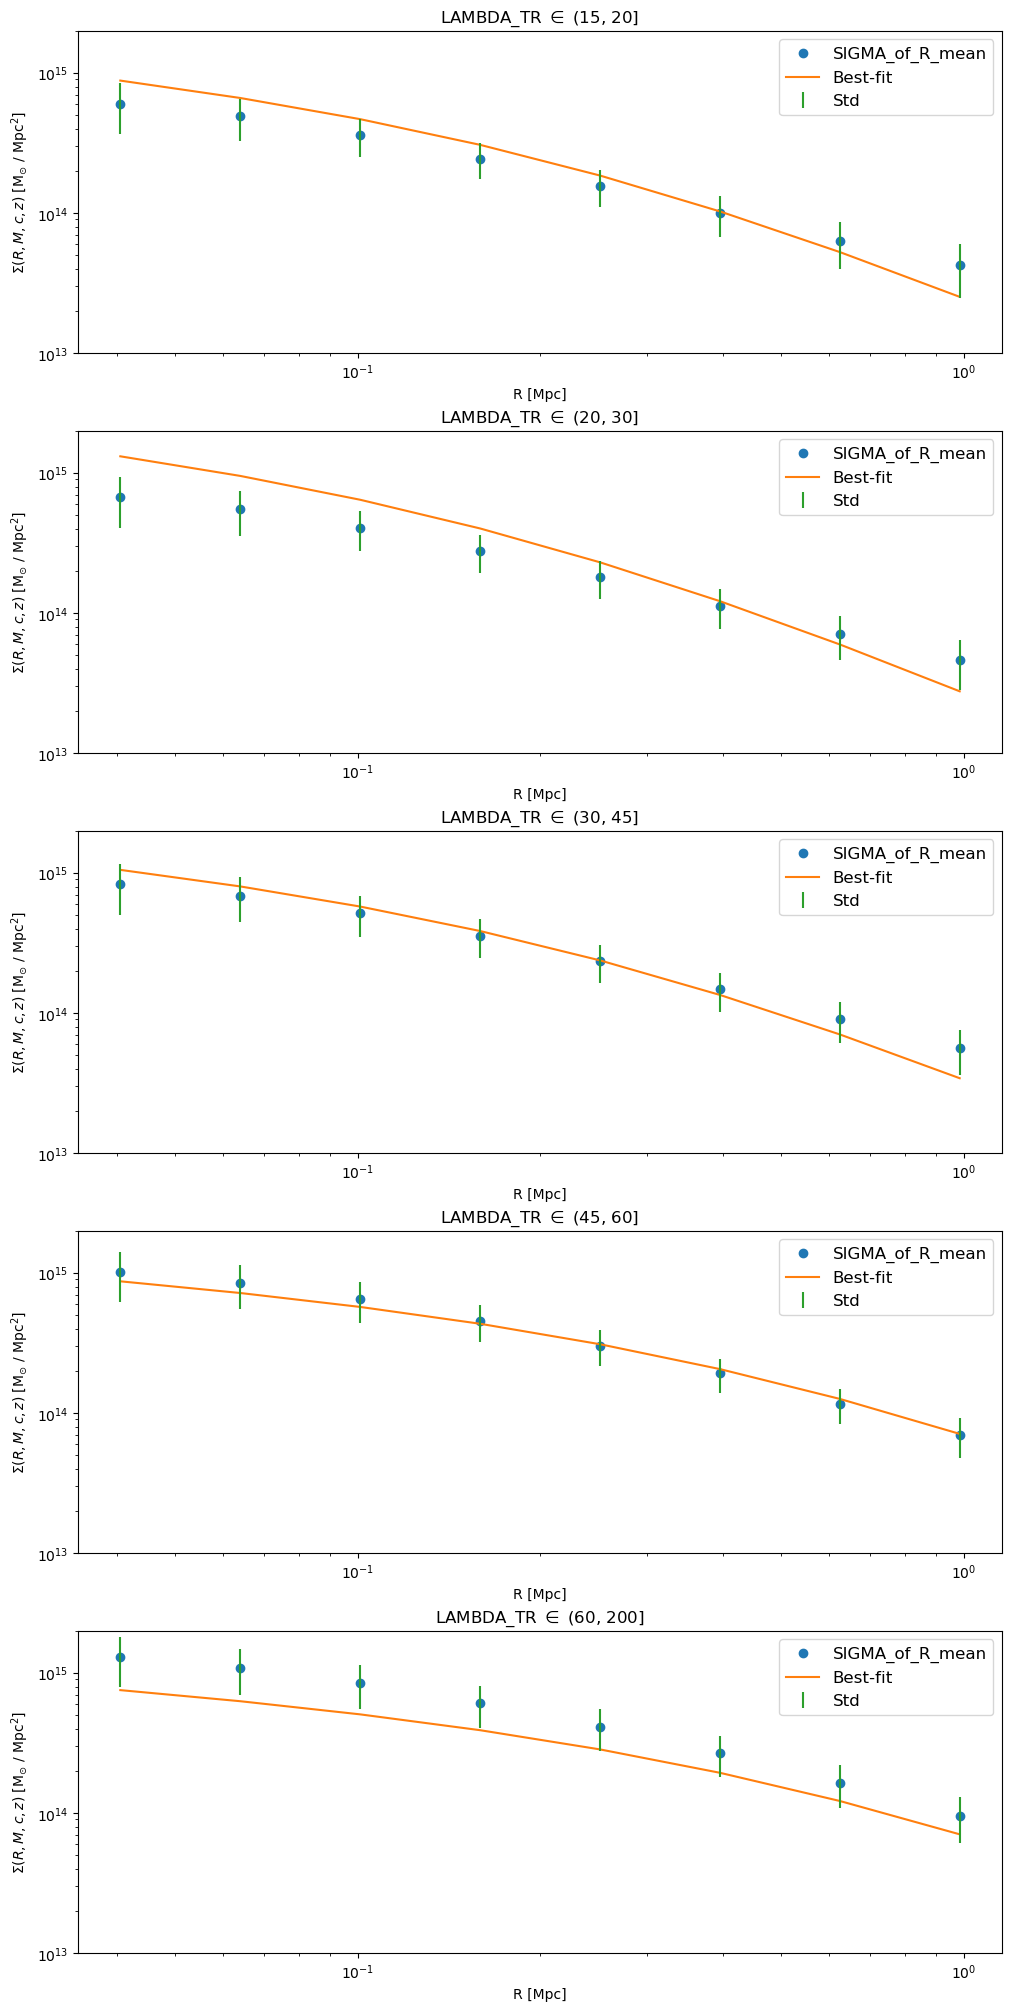

In [43]:
fig, axs = plt.subplots(5, figsize = (10, 20), layout = 'constrained')

for i in range(5):
    axs[i].scatter(R, R_int_mean.T.to_numpy()[:,i], label = 'SIGMA_of_R_mean')
    axs[i].plot(R, Sigma(R, flat_samples[i][np.random.randint(0, flat_samples[k].shape[0]), 0],
                         flat_samples[i][np.random.randint(0, flat_samples[k].shape[0]), 1], z[i]),
                color = 'tab:orange', label = 'Best-fit')
    axs[i].errorbar(R, R_int_mean.T.to_numpy()[:,i], np.sqrt(var[i]), fmt = 'none', color = 'tab:green', label = 'Std')
    axs[i].legend(fontsize = 'large')
    axs[i].set(xlabel = 'R [Mpc]', ylabel = r'$\Sigma(R, M, c, z)$ [M$_{\odot}$ / Mpc$^2$]',
               xscale = 'log', yscale = 'log', ylim = [1e13, 2e15], title = r'LAMBDA_TR $\in$ (%i, %i]' %(lamb[i],lamb[i+1]))
    print(flat_samples[i][np.random.randint(0, flat_samples[k].shape[0]), 0], flat_samples[i][np.random.randint(0, flat_samples[k].shape[0]), 1])

Ho voluto inserire anche questo secondo set di grafici perché rende ancor più evidente il fatto che l'errore sia sovrastimato. In effetti si nota come le barre d'errore siano così grandi che una funzione di fit con parametri $M$ e $c$ casuali (anche se comunque interne agli intervalli di _prior_) le intersechi comunque in più dei due terzi dei casi.

Alla luce di questi risultati, si conclude quindi che l'incertezza sulla rilevazione dei dati sia troppo alta per poter valutare la bontà del fit.